In [117]:
# # This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

# ## 1. Setup Environment

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
# #!pip show pytorch-gradcam
# #!ls /usr/local/lib/python3.11/dist-packages/


In [118]:
## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import timm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm



In [119]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置: {device}")

使用裝置: cuda:0


# 計算 CIFAR-10 的均值和標準差

In [120]:

# 先載入資料集而不進行正規化，只進行 ToTensor
temp_transform = transforms.Compose([
    transforms.ToTensor()
])

temp_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=temp_transform)
temp_trainloader = DataLoader(temp_trainset, batch_size=128, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.
for data, _ in temp_trainloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("CIFAR-10 訓練集的均值:", mean)
print("CIFAR-10 訓練集的標準差:", std)

Files already downloaded and verified
CIFAR-10 訓練集的均值: tensor([0.4914, 0.4822, 0.4465])
CIFAR-10 訓練集的標準差: tensor([0.2023, 0.1994, 0.2010])


# Dataset

In [121]:
## 3. Data Preparation

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [122]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [123]:
# CIFAR-10 的類別名稱
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [124]:
# def imshow(img):
#     # ImageNet 的均值和標準差
#     mean=[0.4914, 0.4822, 0.4465]
#     std=[0.2023, 0.1994, 0.2010]
#     # 反正規化
#     # img 是 PyTorch Tensor，需要轉換為 NumPy array
#     # 首先將 C, H, W 轉為 H, W, C (matplotlib 需要這個格式)
#     img = img.numpy().transpose((1, 2, 0))
#     img = std * img + mean # 乘以標準差，加上均值
#     img = np.clip(img, 0, 1) # 將像素值裁剪到 0-1 範圍內，以防超出
#     plt.imshow(img)
#     plt.show()

# # 獲取一個批次的訓練圖片
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # 顯示圖片
# print('圖片的形狀 (batch_size, channels, height, width):', images.shape)
# print('圖片的標籤:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

# # 選擇要顯示的圖片數量 (例如顯示前 4 張)
# num_images_to_show = 4

# # 創建一個網格來顯示多張圖片
# fig, axes = plt.subplots(1, num_images_to_show, figsize=(10, 3)) # 調整 figsize 以獲得更好的視覺效果

# for i in range(num_images_to_show):
#     ax = axes[i]
#     # 將單張圖片轉換為 NumPy array 並反正規化
#     img = images[i]
#     mean_np = np.array(mean)
#     std_np = np.array(std)
#     img = img.numpy().transpose((1, 2, 0)) # PyTorch: (C, H, W) -> Matplotlib: (H, W, C)
#     img = std_np * img + mean_np
#     img = np.clip(img, 0, 1) # 確保像素值在 0 到 1 之間

#     ax.imshow(img) # 顯示圖片
#     ax.set_title(classes[labels[i]]) # 顯示圖片類別
#     ax.axis('off') # 關閉座標軸

# plt.tight_layout() # 自動調整子圖參數，使之填充整個圖形區域
# plt.show()

# Model

In [125]:
## 4. Model Setup

# Load pre-trained models
#vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)


# Modify classification heads
# For ViT
#vit_model.head = nn.Linear(vit_model.head.in_features, 10)

# For SWIN: Custom head with correct pooling and feature handling
class SwinHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SwinHead, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Reduce [batch, C, H, W] to [batch, C, 1, 1]
        self.fc = nn.Linear(in_channels, num_classes)  # Map to num_classes

    def forward(self, x):
        #print(f"Feature map shape before permute: {x.shape}")  # Debug
        # Transpose from [batch, H, W, C] to [batch, C, H, W]
        x = x.permute(0, 3, 1, 2)
        #print(f"Feature map shape after permute: {x.shape}")  # Debug
        x = self.global_pool(x)  # Shape: [batch, C, 1, 1]
        x = x.flatten(1)  # Shape: [batch, C]
        #print(f"Shape after flattening: {x.shape}")  # Debug
        x = self.fc(x)  # Shape: [batch, num_classes]
        return x

# Debug: Inspect SWIN model feature dimension
#dummy_input = torch.randn(1, 3, 224, 224).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
#swin_model.eval()
#with torch.no_grad():
#    feature_map = swin_model.forward_features(dummy_input)
#    print(f"SWIN feature map shape: {feature_map.shape}")

# Apply custom head to SWIN (assuming 1024 channels, adjusted if debug shows otherwise)
swin_model.head = SwinHead(in_channels=1024, num_classes=10)
# swin_model.head = nn.Linear(swin_model.head.in_features, 10)


#vit_model.to(device)
swin_model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [126]:
# # 冷凍所有參數
# for param in swin_model.parameters():
#     param.requires_grad = False

# # 只訓練分類頭
# for param in swin_model.head.parameters():
#     param.requires_grad = True


In [127]:
# ## 5. Training Function

# def train_model(model, trainloader, criterion, optimizer, schedule, num_epochs=1, checkpoint_dir='./checkpoints'):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_samples = 0
#     losses = []
#     accuracies = []
#     best_accuracy = -1.0 # 初始化最佳準確度

#      # 確保檢查點目錄存在
#     if not os.path.exists(checkpoint_dir):
#         os.makedirs(checkpoint_dir)
    
#     for epoch in range(num_epochs):
#         model.train()
#         with tqdm(total=len(trainloader), desc="Training") as pbar:
#             for i, (inputs, labels) in enumerate(trainloader):
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 # Debug: Print shapes to verify
#                 #print(f"Inputs shape: {inputs.shape}")
#                 #print(f"Labels shape: {labels.shape}")

#                 # Ensure labels are 1D
#                 if labels.dim() > 1:
#                     labels = labels.squeeze()
#                 if labels.dim() == 0:
#                     labels = labels.unsqueeze(0)

#                 optimizer.zero_grad()
#                 outputs = model(inputs)

#                 #print(f"Outputs shape: {outputs.shape}")

#                 # Compute loss
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_samples += labels.size(0)
#                 correct_predictions += (predicted == labels).sum().item()

#                 # print("predicted:", predicted)
#                 # print("labels:", labels)

#                 pbar.set_postfix({'Loss': running_loss / total_samples,
#                                   'Accuracy': 100 * correct_predictions / total_samples})
#                 pbar.update(1)

#         # # Step the scheduler
#         # if schedule is not None:
#         #     schedule.step()
            
#         epoch_loss = running_loss / total_samples
#         epoch_acc = 100 * correct_predictions / total_samples
#         losses.append(epoch_loss)
#         accuracies.append(epoch_acc)
#         print(f"Epoch {epoch+1:>3} - 訓練 Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

#         # Save the model if it has improved
#         if epoch_acc > best_accuracy:
#             best_accuracy = epoch_acc
#             checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth")
#             torch.save(model.state_dict(), checkpoint_path)
#             print(f"最佳模型已儲存於: {checkpoint_path}")





In [128]:
# ## 5. Training Function

def train_model(model, trainloader, criterion, optimizer, schedule, num_epochs=1, checkpoint_dir='./checkpoints'):
    losses = []
    accuracies = []
    best_accuracy = -1.0
    
    for epoch in range(num_epochs):
        model.train()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with tqdm(total=len(trainloader), desc=f"Training Epoch {epoch+1}/{num_epochs}") as pbar:
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                pbar.set_postfix({
                    'Loss': running_loss / total_samples,
                    'Acc': f"{100 * correct_predictions / total_samples:.2f}%"
                })
                pbar.update(1)

        epoch_loss = running_loss / total_samples
        epoch_acc = 100 * correct_predictions / total_samples
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # Step the scheduler
        if schedule is not None:
            schedule.step()

        print(f"[Epoch {epoch+1:>2}] Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

        # Save best model
        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"儲存最佳模型: {checkpoint_path}")


In [129]:
## 6. Fine-tuning

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
#vit_optimizer = optim.AdamW(vit_model.parameters(), lr=0.001)
swin_optimizer = optim.AdamW(swin_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(swin_optimizer, step_size=10, gamma=0.1)
scheduler = None

# Train models
#print("Training Vision Transformer...")
#train_model(vit_model, trainloader, criterion, vit_optimizer)
print("Training SWIN Transformer...")
train_model(swin_model, trainloader, criterion, swin_optimizer, scheduler, num_epochs=5)

Training SWIN Transformer...


Training Epoch 1/5: 100%|██████████| 1563/1563 [04:00<00:00,  6.50it/s, Loss=0.149, Acc=96.09%]


[Epoch  1] Loss: 0.1495 | Accuracy: 96.09%
儲存最佳模型: ./checkpoints\best_model_epoch_1.pth


Training Epoch 2/5: 100%|██████████| 1563/1563 [04:01<00:00,  6.48it/s, Loss=0.0296, Acc=99.11%]


[Epoch  2] Loss: 0.0296 | Accuracy: 99.11%
儲存最佳模型: ./checkpoints\best_model_epoch_2.pth


Training Epoch 3/5: 100%|██████████| 1563/1563 [04:01<00:00,  6.48it/s, Loss=0.015, Acc=99.58%]  


[Epoch  3] Loss: 0.0150 | Accuracy: 99.58%
儲存最佳模型: ./checkpoints\best_model_epoch_3.pth


Training Epoch 4/5: 100%|██████████| 1563/1563 [04:01<00:00,  6.48it/s, Loss=0.0113, Acc=99.67%] 


[Epoch  4] Loss: 0.0113 | Accuracy: 99.67%
儲存最佳模型: ./checkpoints\best_model_epoch_4.pth


Training Epoch 5/5: 100%|██████████| 1563/1563 [04:00<00:00,  6.49it/s, Loss=0.008, Acc=99.77%]  


[Epoch  5] Loss: 0.0080 | Accuracy: 99.77%
儲存最佳模型: ./checkpoints\best_model_epoch_5.pth


In [147]:
loaded_model = timm.create_model('swin_base_patch4_window7_224', pretrained=False)
loaded_model.head = SwinHead(in_channels=1024, num_classes=10)
loaded_model.load_state_dict(torch.load("checkpoints/best_model_epoch_5.pth"))
swin_model = loaded_model
swin_model.eval()
swin_model.to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_108300\1226362533.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("checkpoints/best_mo

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [148]:
## 7. Evaluation

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

#print("Evaluating Vision Transformer...")
#vit_accuracy = evaluate_model(vit_model, testloader)
print("Evaluating SWIN Transformer...")
swin_accuracy = evaluate_model(swin_model, testloader)


Evaluating SWIN Transformer...
Accuracy: 98.69%


SWIN Transformer Grad-CAM


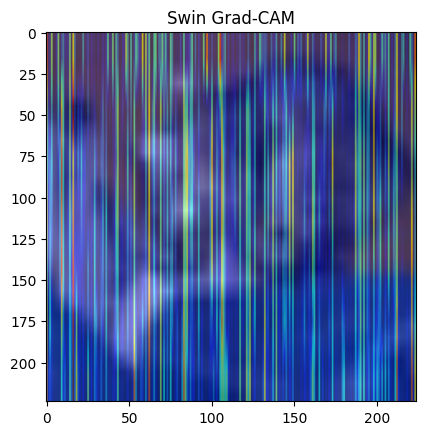

In [152]:
## 8. Grad-CAM Visualization
swin_model.eval()

# Select a random image from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)

# Define Grad-CAM for each model
#vit_target_layer = vit_model.blocks[-1].norm1
swin_target_layer = swin_model.layers[-1].blocks[-1].norm1

#vit_cam = GradCAM(model=vit_model, target_layers=[vit_target_layer], use_cuda=True)
swin_cam = GradCAM(model=swin_model, target_layers=[swin_target_layer])

# Generate CAMs
#vit_grayscale_cam = vit_cam(input_tensor=img, targets=None)
swin_grayscale_cam = swin_cam(input_tensor=img, targets=None)

def denormalize(tensor, mean, std):
    """
    將 Tensor 反標準化並裁切到 [0, 1] 範圍
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Visualize
def visualize_cam(grayscale_cam, img):
    mean= [0.4914, 0.4822, 0.4465]
    std=[0.2023, 0.1994, 0.2010]
    img = img.clone().cpu()
    img = denormalize(img, mean, std)
    img_np = img.permute(1, 2, 0).numpy()
    cam = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    plt.imshow(cam)
    plt.title("Swin Grad-CAM")
    plt.show()

#print("Vision Transformer Grad-CAM")
#visualize_cam(vit_grayscale_cam[0], images[0])
print("SWIN Transformer Grad-CAM")
visualize_cam(swin_grayscale_cam[0], images[0])